# ANÁLISIS DE LA PREDICCIÓN DE ICTUS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

In [3]:
# Cargamos el df para visualizarlo:
df_stroke_prediction = pd.read_csv("../data/healthcare-dataset-stroke-data.csv")
df_stroke_prediction.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [4]:
# Obtenemos más información:
df_stroke_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


**Dataset:** healthcare-dataset-stroke-data.csv  
**Descripción:** Datos de 5110 personas distintas, distinguiendo entre su ID, sexo, edad, tipo de trabajo
y residencia, si están casados, fuman, tienen hipertensión, enfermedad cardiaca, han tenido ictus, o 
nivel de glucosa y BMI.  
**Periodo:**  No especifica.


| Nombre del campo | Descripción                                      | Tipo de variable | Importancia Inicial | Notas |
|------------------|--------------------------------------------------|------------------|---------------------|-------|
| id               | id de cada persona                               | Índice único     |            -        |organizar dataset por id|
| gender           | sexo femenino/masculino                          | Categórica       |          2          |       |
| age              | edad de la persona                               | Numérica discreta|        1            | dividir entre menores 18 y adultos, senior =+65|
| hypertension     | si tiene hipertensión o no                       | Binaria          |        0            |       |
| heart_disease    | si tiene una cardiopatía o no                    | Binaria          |           1         |       |
| ever_married     | si están casados o no                            | Binaria          |           3         |       |
| work_type        | tipo de trabajo                                  | Categórica       |           3         |       |
| residence_type   | tipo de residencia                               | Binaria          |           3         |       |
| avg_glucose_level| valor promedio de glucosa                        | Numérica continua|          1          |       |
| bmi              | (Body Mass Index) - IMC, índice de Masa Corporal | Numérica discreta|            1        | bivariante - con glucosa      |
| smoking_status   | si fuma o no                                     | Categórica       |          1          | multivariante - relación con heart disease y hypertension      |
| stroke           | si ha tenido ictus o no                          | Binaria          |           0         | bivariante - stroke con hypertension|



### Selección y limpieza del dataset ###

A partir de la información general del dataset, vamos a clasificar las variables según su cardinalidad. A partir de ello, vemos que la columna *bmi* tiene valores faltantes. Para tratarlos, es conveniente usar la **media**, ya que es una variable del tipo numérica discreta. Además, la variable **age** tiene valores decimales, con lo que es conveniente que sea un número entero, teniendo en cuenta que la edad de valor 0 son bebés entre 0 y 11 meses. 

In [6]:
# Buscamos la cardinalidad de las variables para clasificarlas:

df_tipos_variables = pd.DataFrame([df_stroke_prediction.nunique(), df_stroke_prediction.nunique()/len(df_stroke_prediction) * 100, df_stroke_prediction.dtypes]).T.rename(columns = {0: "Card",\
                                                                                                                                 1: "%_Card", 2: "Tipo"})
df_tipos_variables

,Card,%_Card,Tipo
id,5110,100.0,int64
gender,3,0.058708,object
age,104,2.035225,float64
hypertension,2,0.039139,int64
heart_disease,2,0.039139,int64
ever_married,2,0.039139,object
work_type,5,0.097847,object
Residence_type,2,0.039139,object
avg_glucose_level,3979,77.866928,float64
bmi,418,8.180039,float64


In [7]:
# Las clasificamos:

df_tipos_variables["Clasificada_como"] = "Categorica" 
df_tipos_variables.loc[df_tipos_variables.Card == 2, "Clasificada_como"] = "Binaria"
df_tipos_variables.loc[df_tipos_variables["Card"] > 10, "Clasificada_como"] ="Numerica Discreta"
df_tipos_variables.loc[df_tipos_variables["%_Card"] > 30, "Clasificada_como"] = "Numerica Continua"
df_tipos_variables

,Card,%_Card,Tipo,Clasificada_como
id,5110,100.0,int64,Numerica Continua
gender,3,0.058708,object,Categorica
age,104,2.035225,float64,Numerica Discreta
hypertension,2,0.039139,int64,Binaria
heart_disease,2,0.039139,int64,Binaria
ever_married,2,0.039139,object,Binaria
work_type,5,0.097847,object,Categorica
Residence_type,2,0.039139,object,Binaria
avg_glucose_level,3979,77.866928,float64,Numerica Continua
bmi,418,8.180039,float64,Numerica Discreta


In [8]:
df_stroke_prediction.info()
# Solamente hay una columna con null: bmi
# bmi es una variable tipo numérica discreta


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [9]:
# buscamos los null:
df_stroke_prediction["bmi"].value_counts(dropna=False)
# hay 201 valores con null

bmi
NaN     201
28.7     41
28.4     38
27.6     37
26.7     37
       ... 
11.5      1
40.6      1
53.9      1
97.6      1
14.9      1
Name: count, Length: 419, dtype: int64

In [10]:
# Vamos a confirmar los null en la columna bmi:
df_stroke_prediction.loc[df_stroke_prediction["bmi"].isna()]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


In [11]:
# y ahora vamos a buscar la media de bmi para sustituir los null por la media, ya que es una variable del tipo numérica discreta:

df_stroke = df_stroke_prediction.copy()
bmi_mean = df_stroke["bmi"].mean().round(1)

# y la media es 28.9
# y como hemos cambiado valores, hicimos copia de nuestro df, y de aquí en adelante es solamente df_stroke

In [12]:
# y sustituimos los null por la media:
df_stroke.loc[df_stroke["bmi"].isna(), "bmi"] = bmi_mean
df_stroke

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.9,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.9,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [13]:
# Revisamos la columna age, porque es decimal debido a que entre 0 y 11 meses miden la edad del bebé.
df_stroke["age"].describe() 

count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64

In [14]:
df_stroke["stroke"].value_counts() 

stroke
0    4861
1     249
Name: count, dtype: int64

In [15]:
df_stroke["age"].value_counts().sort_index() 

age
0.08       2
0.16       3
0.24       5
0.32       5
0.40       2
        ... 
78.00    102
79.00     85
80.00     70
81.00     60
82.00     56
Name: count, Length: 104, dtype: int64

In [16]:
# La columna age es float, podría ser int: (o no ...)
df_stroke["age"] = df_stroke["age"].astype(int)

In [17]:
# aqui, el valor de age ya no es decimal, es directamente 0
df_stroke["age"].describe()

count    5110.000000
mean       43.215264
std        22.633866
min         0.000000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64

In [18]:
# y confirmamos que ya no tenemos null en bmi, y que age es int:
df_stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   int64  
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 479.2+ KB


In [19]:
df_stroke["smoking_status"].value_counts(normalize=True) *100
# Tenemos que determinar qué hacer con los valores unknown de esta columna, representan poco más del 30% 
# No podemos despreciarlos pero tampoco sustituirlo por otro valor, debe ser tratado como si mismo
# podemos valorarlos por separado, entre los valores conocidos y los valores desconocidos
# y a su vez, compararlos con edad, sexo, bmi ... 

smoking_status
never smoked       37.025440
Unknown            30.215264
formerly smoked    17.318982
smokes             15.440313
Name: proportion, dtype: float64

In [20]:
df_stroke["smoking_status"].value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

In [21]:
# podemos crear una columna nueva donde los valores de Unknown sean True:
df_stroke["smoking_unknown"] = df_stroke["smoking_status"] == "Unknown"
df_stroke["smoking_unknown"].value_counts()

smoking_unknown
False    3566
True     1544
Name: count, dtype: int64

In [22]:
df_stroke.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,smoking_unknown
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,False
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,28.9,never smoked,1,False
2,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,False
3,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,False
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,False
5,56669,Male,81,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1,False
6,53882,Male,74,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1,False
7,10434,Female,69,0,0,No,Private,Urban,94.39,22.8,never smoked,1,False
8,27419,Female,59,0,0,Yes,Private,Rural,76.15,28.9,Unknown,1,True
9,60491,Female,78,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1,True


In [23]:
# la columna gender tiene 3 tipos de elementos
df_stroke["gender"].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [24]:
# Buscamos la moda y sustituimos ese Other por el valor de moda para tener solamente 2 valores, male y female:
gender_mode = df_stroke["gender"].mode()[0]
df_stroke.loc[df_stroke["gender"] == "Other", "gender"] = gender_mode
df_stroke["gender"].value_counts()


gender
Female    2995
Male      2115
Name: count, dtype: int64

## ANÁLISIS UNIVARIANTE ##

### Variables categóricas ###

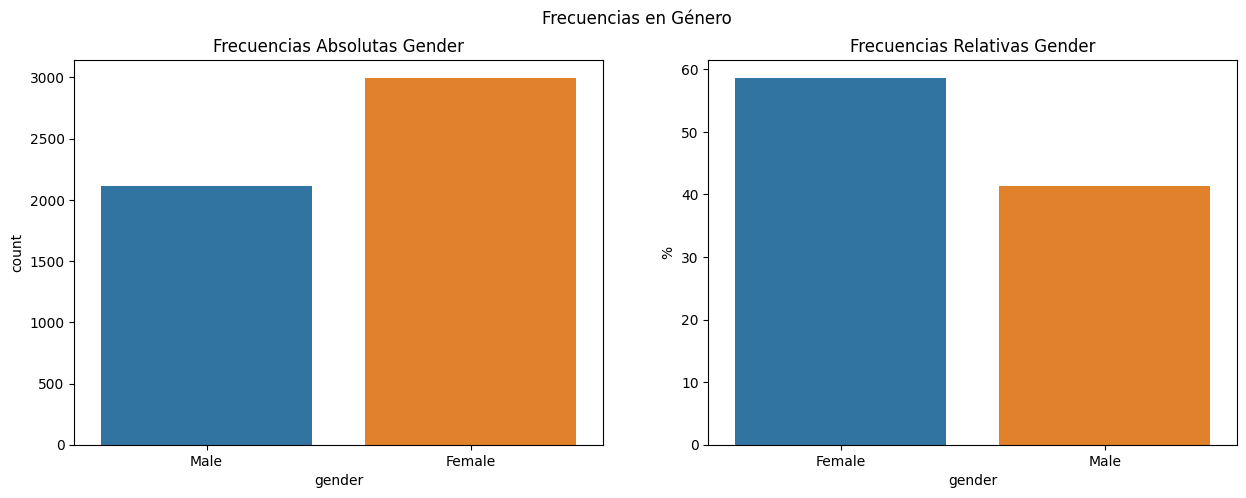

In [26]:
# Barras variable gender:
fig,axs = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
fig.suptitle("Frecuencias en Género");
sns.countplot(x="gender", data = df_stroke, ax = axs[0], hue = "gender", legend =False)
axs[0].set_title("Frecuencias Absolutas Gender")

valores = df_stroke.gender.value_counts(normalize = True) * 100
sns.barplot(x = valores.index, y = valores.values, hue = valores.index, ax = axs[1])
axs[1].set_title("Frecuencias Relativas Gender")
axs[1].set_ylabel("%")
plt.show()

fig.savefig("../img/univariante_gender_barras.png")


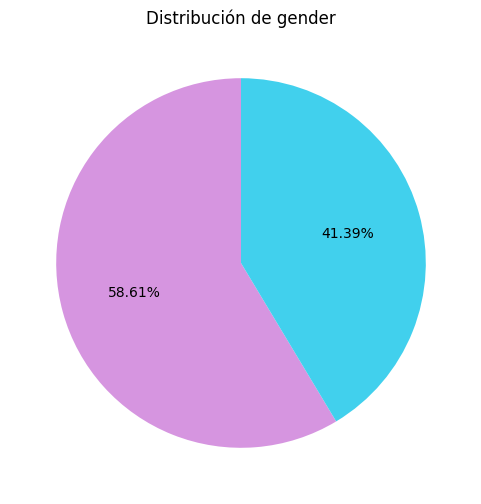

In [27]:
# tarta variable gender:
data = df_stroke["gender"].value_counts()
fig,ax = plt.subplots(1,1,figsize = (6,6))
colors = ["#D695E0", "#41D0ED"]
ax.pie(data.values,
        autopct='%.2f%%', 
        startangle= 90,
        colors=colors)
ax.set_title("Distribución de gender")
plt.show();

fig.savefig("../img/univariante_gender_tarta.png")

Variable *age*:
- El estudio tiene cerca del 58% de personas del sexo femenino, y 42% del sexo masculino.


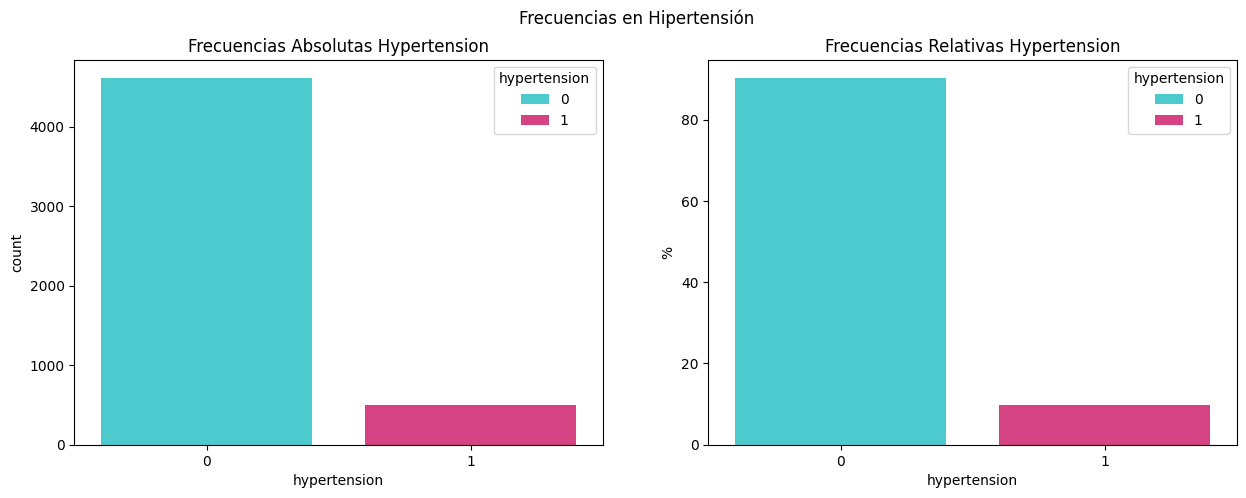

In [28]:
# Barras variable hypertension:
fig,axs = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
fig.suptitle("Frecuencias en Hipertensión");
palette = ["#36DEE4", "#EF2A7F"]
sns.countplot(x="hypertension", data = df_stroke, ax = axs[0], hue = "hypertension", legend = True, palette= palette)
axs[0].set_title("Frecuencias Absolutas Hypertension")

valores = df_stroke.hypertension.value_counts(normalize = True) * 100
sns.barplot(x = valores.index, y = valores.values, hue = valores.index, ax = axs[1], palette=palette)
axs[1].set_title("Frecuencias Relativas Hypertension")
axs[1].set_ylabel("%")
plt.show();

fig.savefig("../img/univariante_hypertension_barra.png")

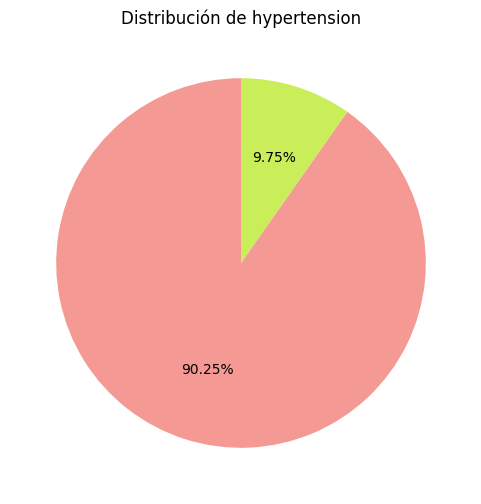

In [29]:
# tarta variable hypertension:
data = df_stroke["hypertension"].value_counts()
fig,ax = plt.subplots(1,1,figsize = (6,6))
colors = ["#F59995", "#C9EE5A"]
ax.pie(data.values,
        autopct='%.2f%%', 
        startangle= 90,
        colors=colors)
ax.set_title("Distribución de hypertension")
plt.show();
fig.savefig("../img/univariante_hypertension_tarta.png")

Variable *hypertension*:
- Menos del 10% de personas tienen hipertensión.


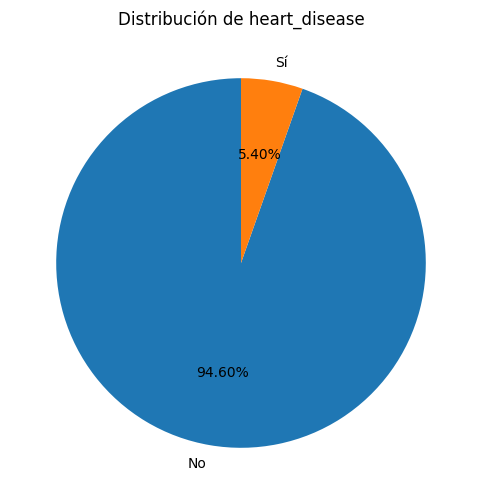

In [30]:
# tarta variable heart_disease:
data = df_stroke["heart_disease"].value_counts()
fig,ax = plt.subplots(1,1,figsize = (6,6))
labels = ["No", "Sí"]
ax.pie(data.values,
        labels= labels,
        autopct='%.2f%%', startangle= 90)
ax.set_title("Distribución de heart_disease")
plt.show();
fig.savefig("../img/univariante_heart_disease_tarta.png")

Variable *heart_disease*
- Alrededor del 5% tienen alguna enfermedad cardiaca.


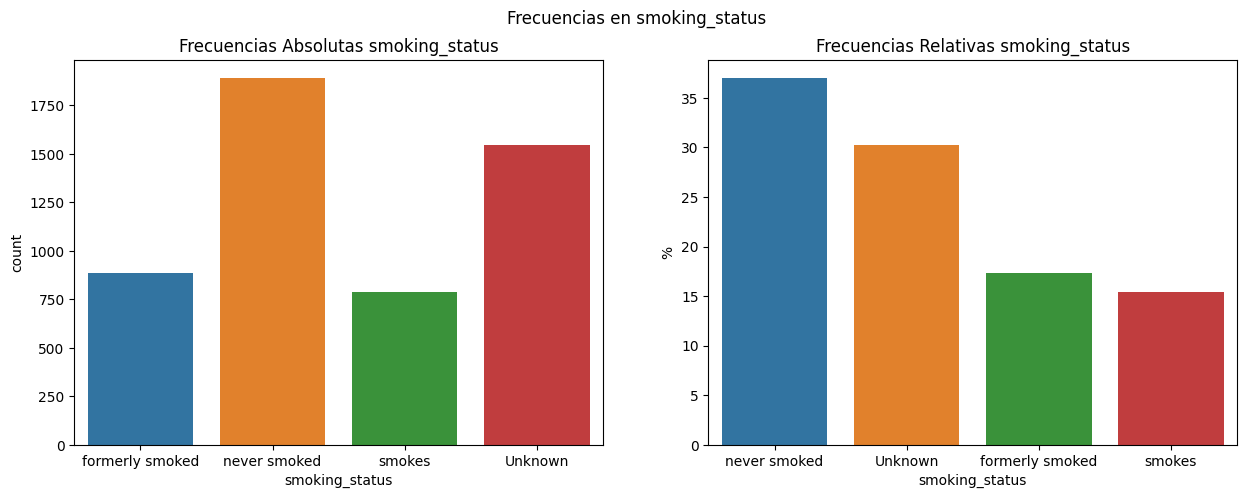

In [31]:
# barras variable smoking_status:
fig,axs = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
fig.suptitle("Frecuencias en smoking_status");
sns.countplot(x="smoking_status", data = df_stroke, ax = axs[0], hue = "smoking_status", legend = False)
axs[0].set_title("Frecuencias Absolutas smoking_status")

valores = df_stroke.smoking_status.value_counts(normalize = True) * 100
sns.barplot(x = valores.index, y = valores.values, hue = valores.index, ax = axs[1])
axs[1].set_title("Frecuencias Relativas smoking_status")
axs[1].set_ylabel("%")
plt.show();
fig.savefig("../img/univariante_smoking_status_barras.png")

Variable *smoking_status*
- Hay más personas que nunca han fumado, que las que fumaban o no en el momento del estudio. Y hay aproximadamente un 30% que se desconoce. 


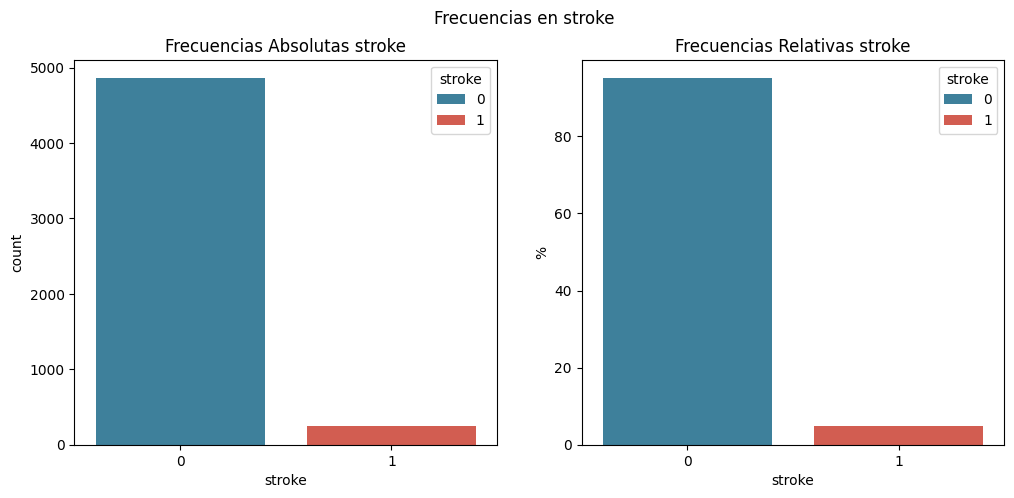

In [32]:
# barras variable stroke:
fig,axs = plt.subplots(nrows=1,ncols=2, figsize=(12,5))
fig.suptitle("Frecuencias en stroke");
palette = ["#2E86AB", "#E74C3C"]
sns.countplot(x="stroke", data = df_stroke, ax = axs[0], hue = "stroke", legend = True, palette=palette)
axs[0].set_title("Frecuencias Absolutas stroke")

valores = df_stroke.stroke.value_counts(normalize = True) * 100
sns.barplot(x = valores.index, y = valores.values, hue = valores.index, ax = axs[1], palette=palette)
axs[1].set_title("Frecuencias Relativas stroke")
axs[1].set_ylabel("%")
plt.show();
fig.savefig("../img/univariante_stroke_barras.png")

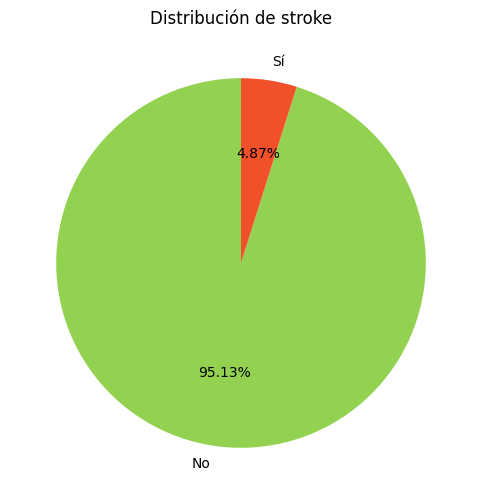

In [33]:
# tarta variable stroke
data = df_stroke["stroke"].value_counts()
fig,ax = plt.subplots(1,1,figsize = (6,6))
labels = ["No", "Sí"]
colors = ["#93D250", "#F0512A"]
ax.pie(data.values,
        labels= labels,
        autopct='%.2f%%', 
        startangle= 90,
        colors=colors)
ax.set_title("Distribución de stroke")
plt.show();
fig.savefig("../img/univariante_stroke_tarta.png")

Variable *stroke*:
- Menos del 5% han tenido ictus.


### Variables numéricas ###

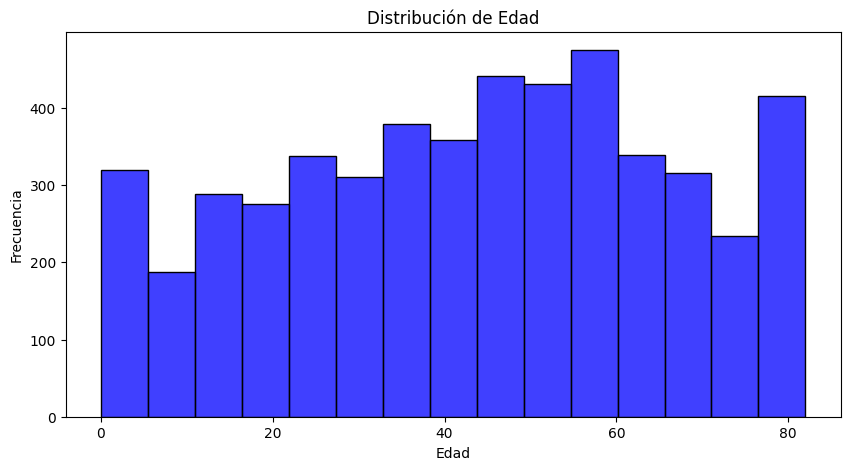

In [34]:
# Histograma variable age:
plt.figure(figsize=(10,5))
sns.histplot(df_stroke["age"], bins=15, kde=False, color="b")
plt.title("Distribución de Edad")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.show()
fig.savefig("../img/univariante_age_histograma.png")

Variable *age*:
- Las edades van desde los 0 años a los 82.

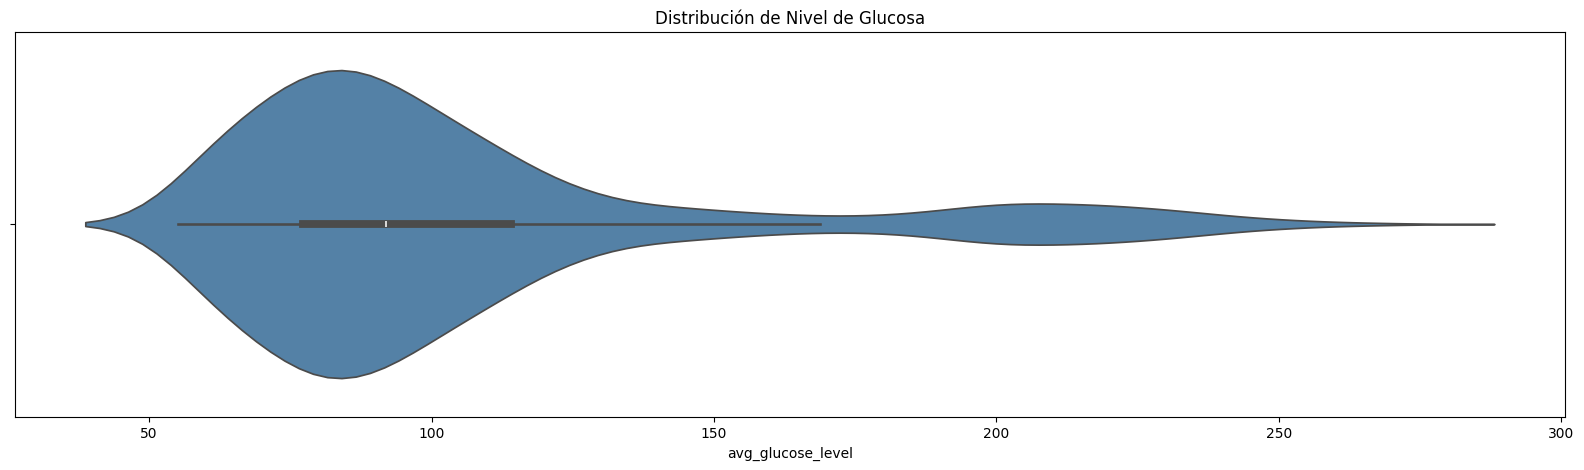

In [35]:
# violin variable avg_glucose_level:
plt.figure(figsize=(20,5))
plt.title("Distribución de Nivel de Glucosa")
sns.violinplot(df_stroke["avg_glucose_level"], color="steelblue", orient="h");
fig.savefig("../img/univariante_avg_glucose_level_violin.png")

Variable numérica continua *avg_glucose_level*:
- Los valores de glucosa se concentran en su mayoría entre 50 y 150.


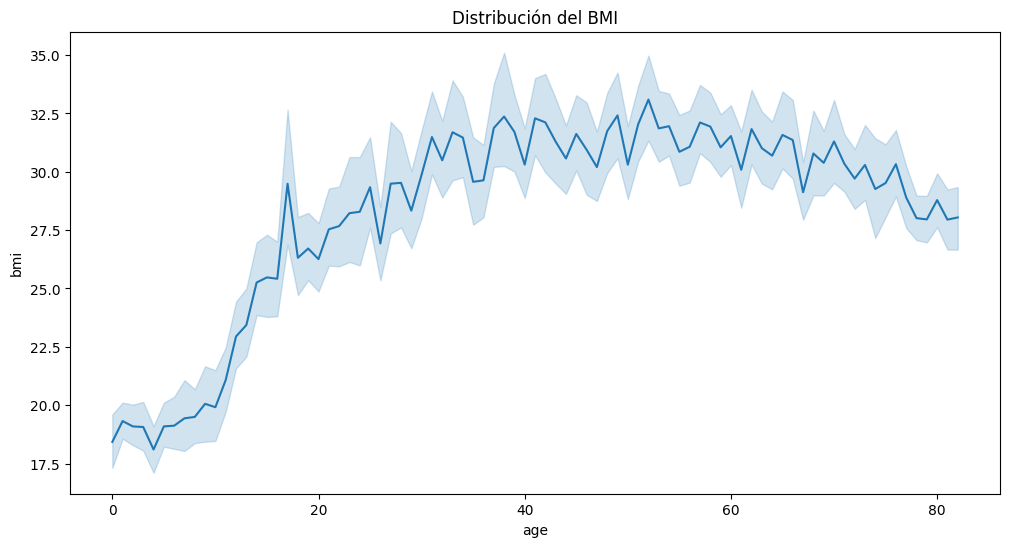

In [36]:
# evolución variable bmi según la variable age:
plt.figure(figsize=(12,6))
plt.title("Distribución del BMI")
sns.lineplot(x=df_stroke.age, y= "bmi", data= df_stroke);
fig.savefig("../img/univariante_bmi_age_evolucion.png")


Variable numérica continua *avg_glucose_level*:
- El BMI aumenta entre los 0 y 30 años; es relativamente estable entre los 30 y 70 años, y disminuye ligeramente entre los 70 y 82 años.

## ANÁLISIS BIVARIANTE ##

Comparamos siempre con stroke (variable directora), que es una variable categórica binaria:
- stroke = 0 → no ocurrencia de ictus
- stroke = 1 → sí ocurrencia de ictus

### Edad vs Ictus
- Variables: age (numérica continua) vs stroke (binaria).
- Hipótesis: si la edad es un factor de riesgo, las personas que han sufrido un ictus serán, de media, mayores que las que no. 

In [ ]:
sns.set_theme(style='whitegrid')

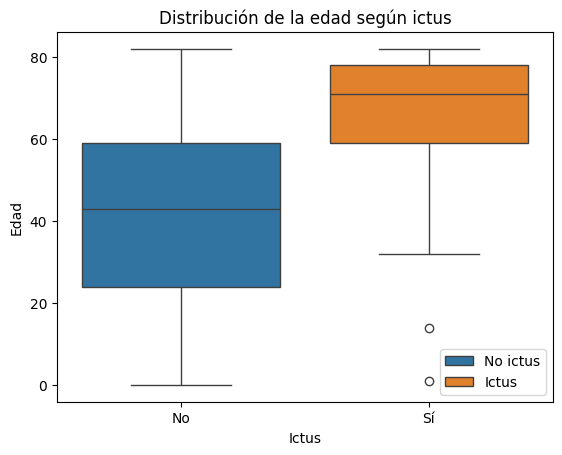

In [37]:
# boxplot
sns.boxplot(
    x='stroke', 
    y='age', 
    hue = 'stroke', 
    data= df_stroke)

plt.xlabel('Ictus')
plt.ylabel('Edad')
plt.title('Distribución de la edad según ictus')
plt.xticks([0, 1], ['No', 'Sí'], rotation=0)
plt.legend(['No ictus', 'Ictus'])
plt.show()
fig.savefig("../img/bivariante_age_stroke_boxplot.png")

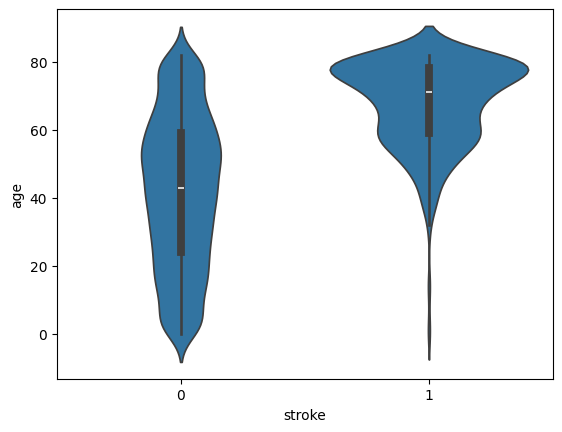

In [38]:
# violin plot
sns.violinplot(
    data=df_stroke,
    x='stroke',
    y='age'
)
plt.show()
fig.savefig("../img/bivariante_age_stroke_violin.png")

- Conclusión: los casos de ictus se concentran claramente en personas de mayor edad, lo que confirma que la edad es uno de los principales factores de riesgo.

### Hipertensión vs Ictus
- Variables: hypertension (binaria) vs stroke (binaria).
- Hipótesis: si la hipertensión arterial es un factor de riesgo, el porcentaje de ictus será mayor en hipertensos.

In [40]:
# tabla de contingencia normalizada
tc = pd.crosstab(df_stroke['hypertension'], df_stroke['stroke'], normalize='index') * 100
tc

stroke,0,1
hypertension,,
0,96.032090,3.967910
1,86.746988,13.253012


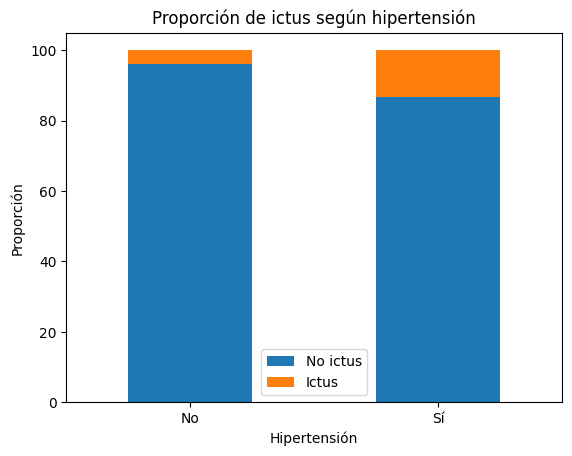

In [41]:
# gráfico de barras apiladas
tc.plot(
    kind='bar',
    stacked=True
)
plt.ylabel('Proporción')
plt.xlabel('Hipertensión')
plt.legend(['No ictus', 'Ictus'])
plt.title('Proporción de ictus según hipertensión')
plt.xticks([0, 1], ['No', 'Sí'], rotation=0)
plt.show()
fig.savefig("../img/bivariante_stroke_hypertension_barras.png")

- Conclusión: la proporción de ictus es mayor en personas con hipertensión, por lo que podemos afirmar que la hipertensión es un factor de riesgo.

### Glucemia vs Ictus
- Variables: avg_glucose_level (numérica continua) vs stroke (binaria)
- Hipótesis: si los niveles de glucemia son un factor de riesgo para la aparición de ictus, aparecerán más elevados en el grupo con ictus. 

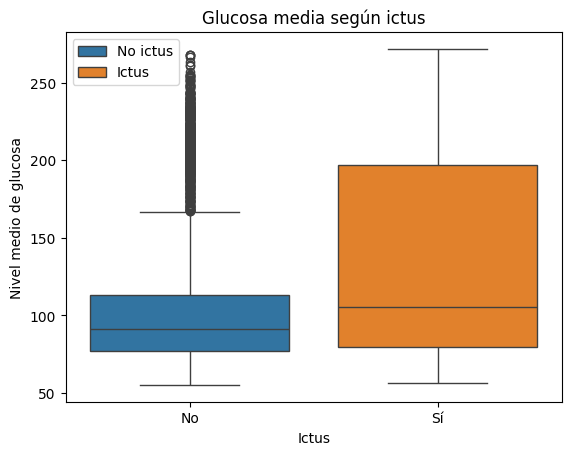

In [43]:
# Boxplot
sns.boxplot(
    x='stroke', 
    y='avg_glucose_level', 
    hue = 'stroke',
    data=df_stroke)

plt.xlabel('Ictus')
plt.ylabel('Nivel medio de glucosa')
plt.title('Glucosa media según ictus')
plt.xticks([0, 1], ['No', 'Sí'], rotation=0)
plt.legend(['No ictus', 'Ictus'])
plt.show()
fig.savefig("../img/bivariante_stroke_avg_glucose_level_boxplot.png")

- Conclusión: los niveles medios de glucosa son más elevados en el grupo con ictus, lo que sugiere un papel como factor de riesgo de esta alteración endocrina. 

### Índice de masa corporal vs Stroke
- Variables: bmi (numérica continua) vs stroke (binaria)
- Hipótesis: si el IMC alto es un factor de riesgo de ictus, éste será mayor en el grupo de afectados. 

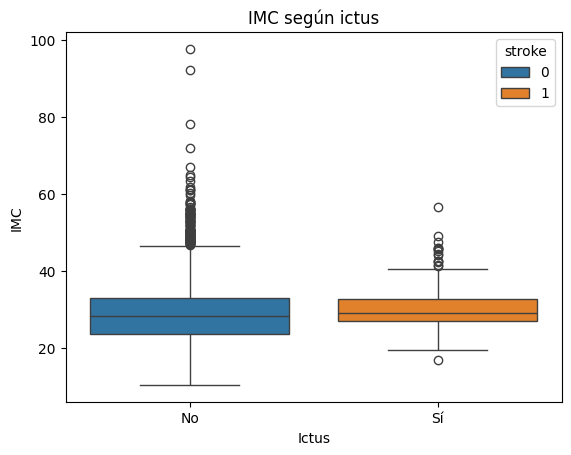

In [44]:
# Boxplot
sns.boxplot(
    x='stroke', 
    y='bmi', 
    hue = 'stroke', 
    data=df_stroke)

plt.xlabel('Ictus')
plt.ylabel('IMC')
plt.title('IMC según ictus')
plt.xticks([0, 1], ['No', 'Sí'], rotation=0)
plt.show()
fig.savefig("../img/bivariante_stroke_bmi_boxplot.png")

- Conclusión: la relación entre IMC e ictus parece ser débil, sin clara separación entre grupos, en comparación con otras variables analizadas anteriormente, como la edad o la hipertensión. 

## ANÁLISIS MULTIVARIANTE ##

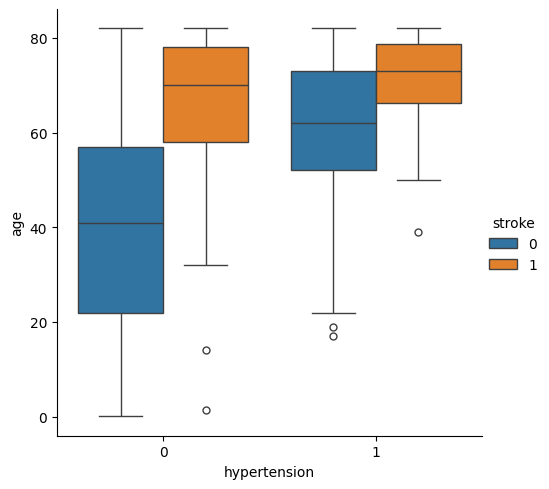

In [45]:
sns.catplot(
    data=df_stroke_prediction,
    x="hypertension",
    y="age",
    hue="stroke",
    kind="box"
)
fig.savefig("../img/multivariante_stroke_hypertension_age_boxplot.png");

### Conclusiones
- En ambos grupos de hipertensión (0 y 1), los individuos que han sufrido un ictus (stroke = 1) presentan una edad media superior a los que no lo han sufrido (stroke = 0).
- La diferencia de edad entre personas con y sin ictus es más pronunciada en el grupo con hipertensión, lo que sugiere una posible interacción entre edad e hipertensión en el riesgo de ictus.
- La dispersión de edad (rango intercuartílico) es mayor en los grupos sin ictus, especialmente entre los no hipertensos, lo que indica mayor variabilidad de edad en ese segmento.
- Los grupos con ictus muestran distribuciones más concentradas en edades avanzadas, lo que refuerza la hipótesis de que el ictus se asocia con edad elevada.
- La presencia de outliers en los grupos sin ictus sugiere que hay individuos jóvenes sin hipertensión que también forman parte del conjunto, lo cual podría ser relevante para análisis de prevención.


/Users/luuu/Desktop/ds-TheBridge/repos-data/EDA_Stroke_Prediction/venv/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/luuu/Desktop/ds-TheBridge/repos-data/EDA_Stroke_Prediction/venv/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/luuu/Desktop/ds-TheBridge/repos-data/EDA_Stroke_Prediction/venv/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/luuu/Desktop/ds-TheBridge/repos-data/EDA_Stroke_Predic

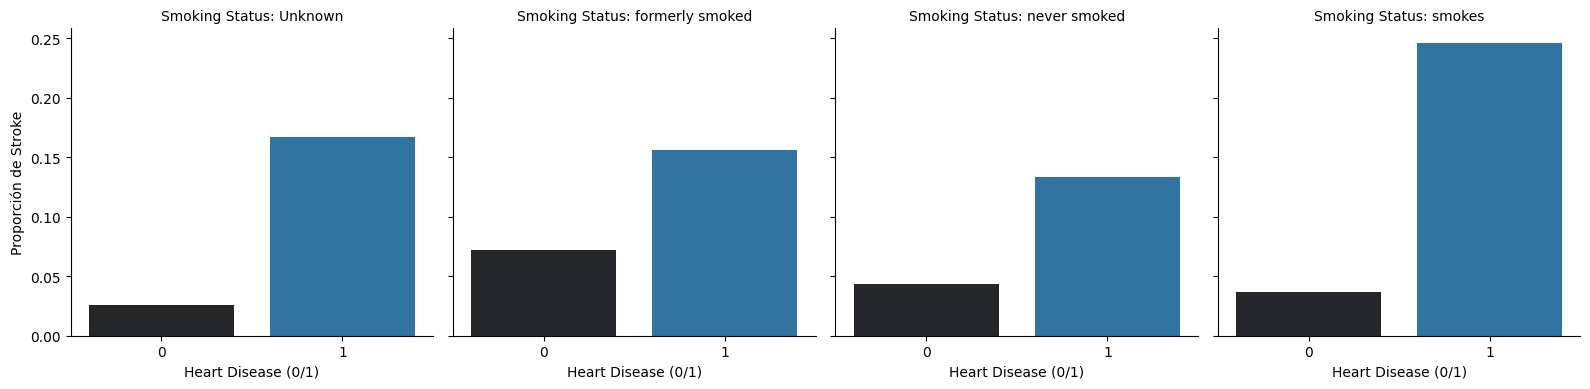

In [46]:
# Calcular proporciones de stroke por grupo
df_grouped = (
    df_stroke_prediction.groupby(["smoking_status", "heart_disease"])["stroke"]
      .mean()
      .reset_index()
)

# Crear FacetGrid por categoría de fumador
g = sns.FacetGrid(df_grouped, col="smoking_status", height=4, sharey=True)

# Barplot sin palette (evita warnings)
g.map_dataframe(
    sns.barplot,
    x="heart_disease",
    y="stroke",
    hue="heart_disease",
    dodge=False,
    legend=False
)

# Etiquetas y títulos
g.set_axis_labels("Heart Disease (0/1)", "Proporción de Stroke")
g.set_titles("Smoking Status: {col_name}");
fig.savefig("../img/multivariante_stroke_heart_disease_smoking_status.png");

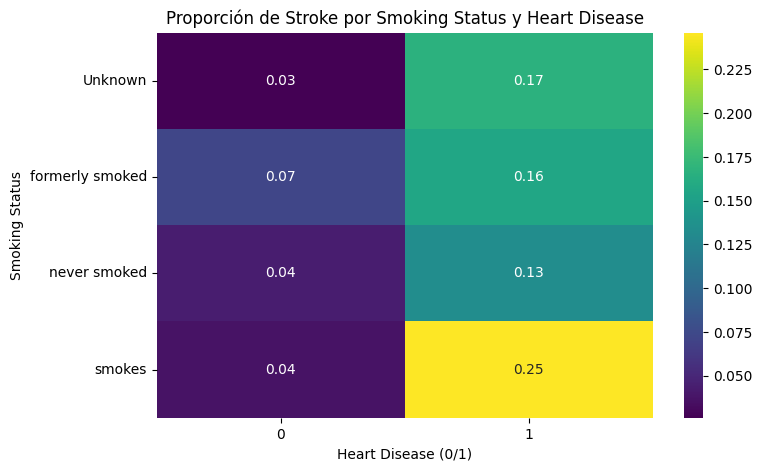

In [47]:

# 1. Calcular proporciones de stroke por grupo
df_grouped = (
    df_stroke_prediction.groupby(["smoking_status", "heart_disease"])["stroke"]
      .mean()
      .reset_index()
)

# 2. Pivotar para crear la matriz del heatmap
heatmap_data = df_grouped.pivot(
    index="smoking_status",
    columns="heart_disease",
    values="stroke"
)

# 3. Dibujar el heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap="viridis",
    fmt=".2f"
)

plt.title("Proporción de Stroke por Smoking Status y Heart Disease")
plt.xlabel("Heart Disease (0/1)")
plt.ylabel("Smoking Status")
plt.show()
fig.savefig("../img/multivariante_stroke_heart_disease_smoking_status_mapa_calor.png");

### Conclusiones:
- En todos los grupos de fumadores, la proporción de stroke es mayor en individuos con enfermedad cardíaca (heart_disease = 1) que en aquellos sin ella (heart_disease = 0), lo que indica una asociación consistente entre enfermedad cardíaca e ictus.
- El grupo "smokes" con enfermedad cardíaca presenta la proporción más alta de stroke (0.25), lo que sugiere que fumar podría amplificar el riesgo asociado a la cardiopatía.
- En el grupo "never smoked", la proporción de stroke es relativamente baja incluso en presencia de enfermedad cardíaca (0.13), lo que podría indicar un efecto protector del no consumo de tabaco.
- El grupo "formerly smoked" muestra una proporción intermedia de stroke, lo que sugiere que el riesgo disminuye tras dejar de fumar, aunque no se iguala al de quienes nunca fumaron.
- El grupo "unknown" presenta una proporción elevada de stroke en presencia de enfermedad cardíaca (0.17), pero su interpretación clínica es limitada debido a la ambigüedad de la categoría.
- La consistencia del patrón en ambos gráficos (barplot y heatmap) refuerza la validez de la relación observada entre smoking status, heart disease y stroke, y justifica el uso de modelos multivariantes para cuantificar el riesgo
